# Simple animal classification model with PyTorch

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import os
import torch

# Set up configs

In [5]:
class C:
    train_img_path = 'animals/cat_and_dog/training_set/'
    val_img_path = 'animals/cat_and_dog/test_set/'

    lr = 0.001
    batch_size = 128
    epochs = 25

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load data

In [3]:
from torchvision.datasets import ImageFolder
from torchvision import transforms as T

In [6]:
train_augs = T.Compose([
#     T.RandomVerticalFlip(0.5),
#     T.RandomHorizontalFlip(0.5),
#     T.RandomRotation(degrees=(-30, +30)),
    T.ToTensor(),
    T.Resize((128,128), antialias=True)
])

val_augs = T.Compose([
    T.ToTensor(),
    T.Resize((128,128), antialias=True) #IMAGE_SIZE=(128,128)
])

train = ImageFolder(C.train_img_path, transform=train_augs)
val = ImageFolder(C.val_img_path, transform=val_augs)

len(train), len(val)

(8005, 2023)

# See an example

torch.Size([3, 128, 128])

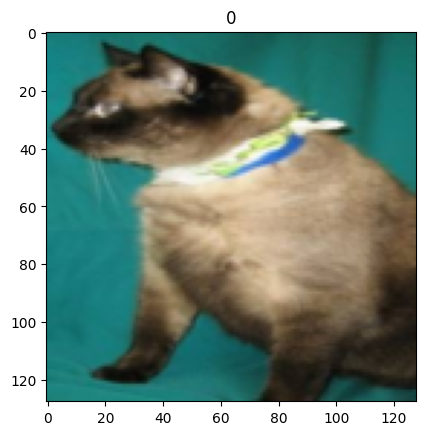

In [7]:
image, label = train[888] # see img at idx

plt.imshow(image.permute(1,2,0)) # from (c, h, w) -> required to show format (h, w, c)
plt.title(label);
image.shape

In [8]:
classes = train.class_to_idx
classes

{'cats': 0, 'dogs': 1}

# Load data into batches

In [9]:
from torch.utils.data import DataLoader

In [10]:
train_loader = DataLoader(train, batch_size=C.batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size=C.batch_size, shuffle=False)

In [11]:
for images, labels in train_loader:
    break

print(f"One image batch shape : {images.shape}") # [batch_size, channels, height, width]
print(f"One label batch shape : {labels.shape}")

One image batch shape : torch.Size([128, 3, 128, 128])
One label batch shape : torch.Size([128])


# Define model

In [12]:
import torch.nn as nn

class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.fc_input_size = 64 * 32 * 32
        
        self.fc1 = nn.Linear(self.fc_input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, len(classes))

        self.dropout = nn.Dropout(p=0.5)
        self.bn1 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm2d(64)
        
    def forward(self, x):

        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))

#         print(x.shape)
        x = x.view(-1, self.fc_input_size) 
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
#         x = self.dropout(x)
        x = self.fc3(x)
        
        return x

In [11]:
import torch.optim as optim

model = CNN().to(C.device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=C.lr)

In [12]:
from tqdm import tqdm

In [13]:
def train(model, train_loader, optimizer, current_epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(C.device), labels.to(C.device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        # get max label out of preds
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if batch_idx % 19 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Training Loss: {:.4f}, Training Accuracy: {:.2f}%'
                      .format(current_epoch + 1, C.epochs, batch_idx + 1, len(train_loader),
                              running_loss / (batch_idx + 1), 100 * correct / total))

    return running_loss / len(train_loader), correct / len(train_loader)


In [14]:
def validation(model, val_loader, current_epoch):
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            images, labels = images.to(C.device), labels.to(C.device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    print('Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%'.format(val_loss / len(val_loader),100 * val_correct / val_total))
   
    return val_loss / len(val_loader), val_correct / len(val_loader)


In [15]:
best_valid_loss = np.Inf

for i in range(C.epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, i)
    valid_loss, valid_acc = validation(model, val_loader, i)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best-weights.pt')
        print('saved-best-weights')
        best_valid_loss = valid_loss

Epoch [1/50], Step [1/211], Training Loss: 1.6210, Training Accuracy: 10.94%
Epoch [1/50], Step [20/211], Training Loss: 2.2584, Training Accuracy: 22.19%
Epoch [1/50], Step [39/211], Training Loss: 1.9157, Training Accuracy: 23.56%
Epoch [1/50], Step [58/211], Training Loss: 1.7820, Training Accuracy: 26.91%
Epoch [1/50], Step [77/211], Training Loss: 1.7078, Training Accuracy: 29.08%
Epoch [1/50], Step [96/211], Training Loss: 1.6650, Training Accuracy: 29.62%
Epoch [1/50], Step [115/211], Training Loss: 1.6284, Training Accuracy: 30.26%
Epoch [1/50], Step [134/211], Training Loss: 1.6041, Training Accuracy: 30.34%
Epoch [1/50], Step [153/211], Training Loss: 1.5799, Training Accuracy: 30.60%
Epoch [1/50], Step [172/211], Training Loss: 1.5586, Training Accuracy: 30.97%
Epoch [1/50], Step [191/211], Training Loss: 1.5401, Training Accuracy: 31.27%
Epoch [1/50], Step [210/211], Training Loss: 1.5257, Training Accuracy: 31.47%
Validation Loss: 1.2738, Validation Accuracy: 42.02%
saved-

In [16]:
classes_list = list(classes.keys())

def view_classify(img, ps):
    ps = ps.cpu().data.numpy().squeeze()
    img = img.cpu().numpy().transpose(1, 2, 0)

    fig, (ax1, ax2) = plt.subplots(figsize=(5, 9), ncols=2)
    ax1.imshow(img)
    ax1.axis('off')
    ax2.barh(classes_list, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes_list)
    ax2.set_yticklabels(classes_list)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

# See predictions + probabilities

/tmp/ipykernel_26/3147126142.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(figsize=(5, 9), ncols=2)


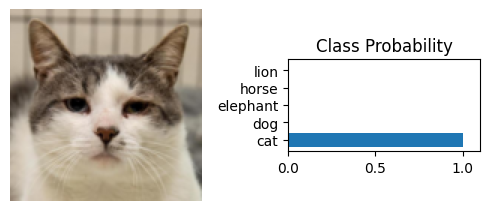

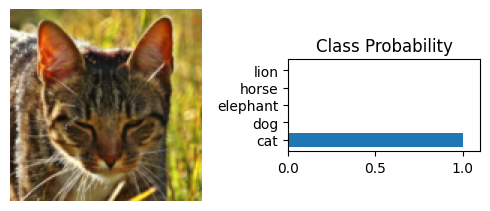

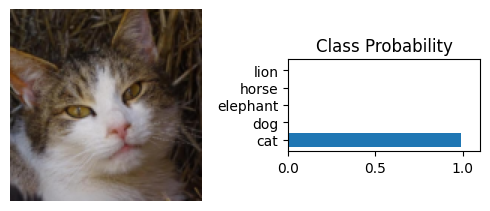

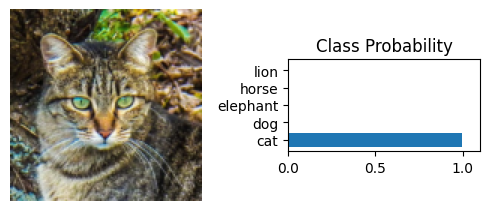

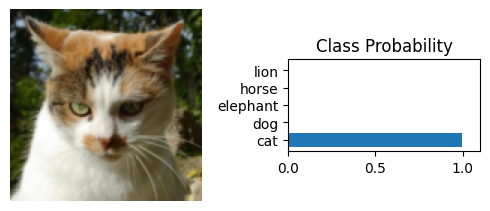

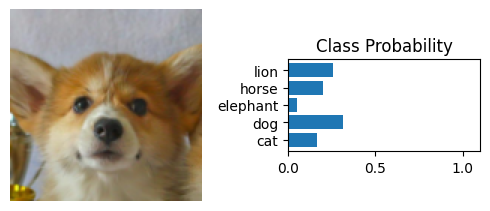

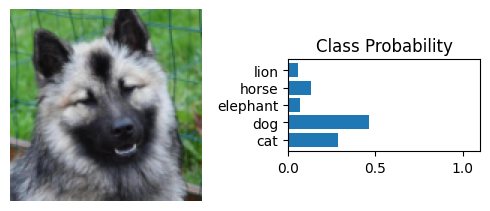

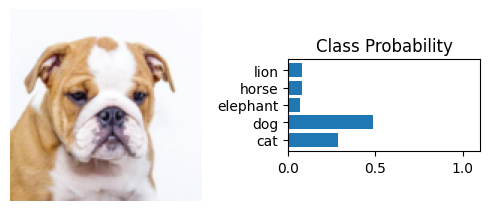

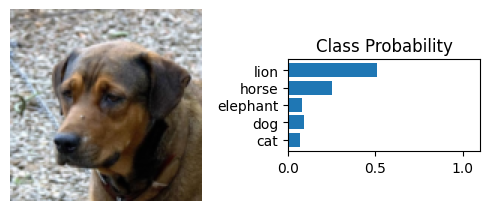

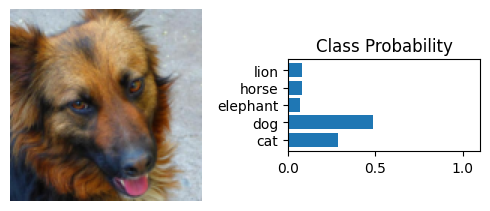

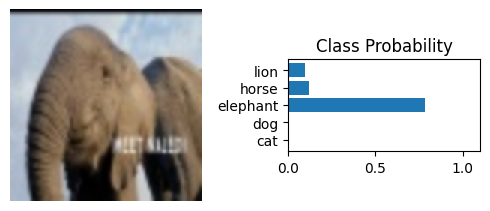

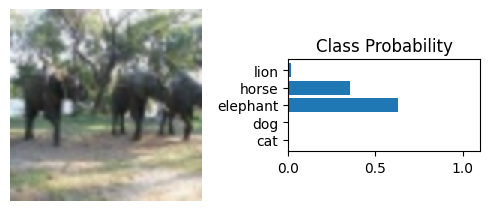

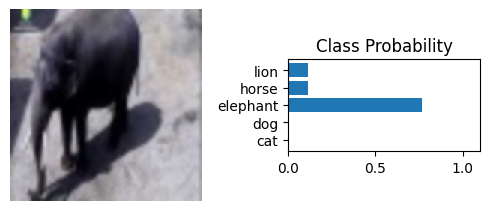

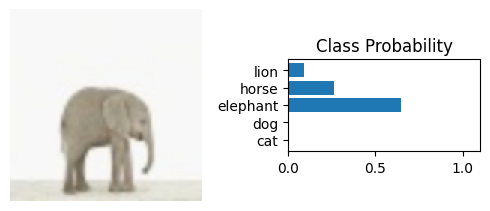

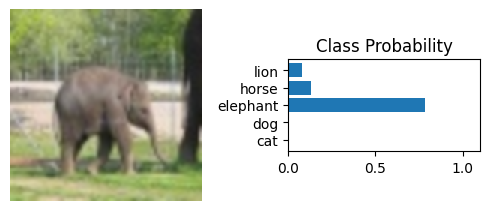

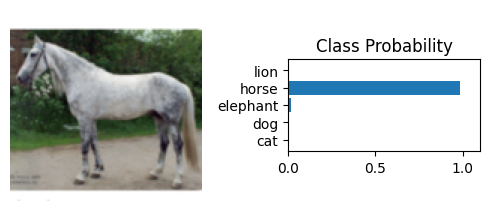

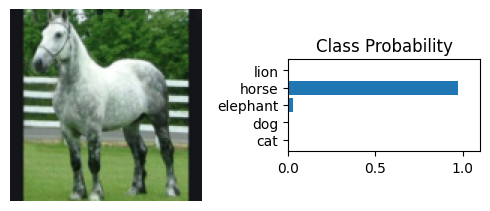

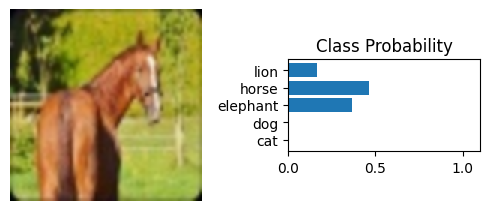

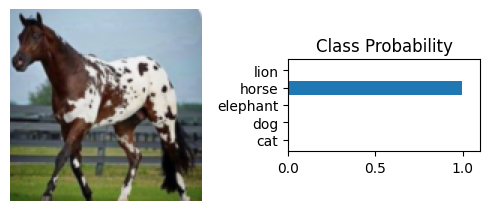

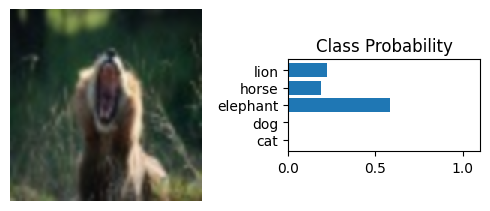

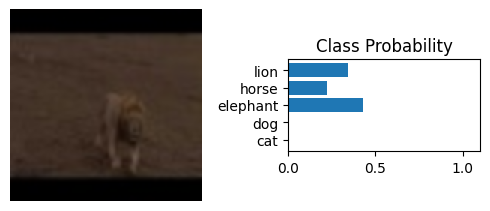

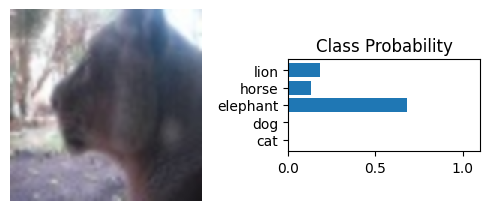

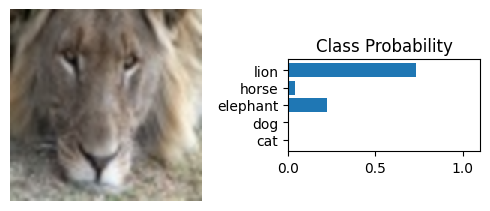

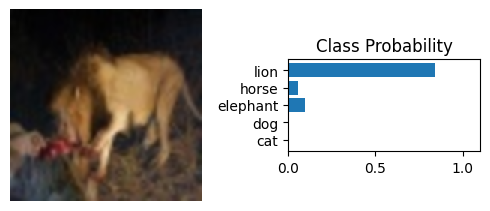

In [17]:
model_state_dict = torch.load('best-weights.pt')

model = CNN()
model.load_state_dict(model_state_dict)
model.eval()
model.to(C.device)

for images, _ in val_loader:
    with torch.no_grad():
        images = images.to(C.device)
        outputs = model(images)
        ps = torch.softmax(outputs, dim=1)

    view_classify(images[1], ps[1])


In [18]:
# import gc
# torch.cuda.empty_cache()
# gc.collect()